In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Collect data in dictionary with key:value given by day_number:DataFrame. 
"""
pd.set_option("display.float_format", "{:.4f}".format)

days = range(8, 13)

abc_filenames = {day:f"./ABC_2024-01-{day:02d}.csv" for day in days}
labc_filenames = {day:f"./LABC_2024-01-{day:02d}.csv" for day in days}

def load_data(filenames):
    data = {}
    for day, filename in filenames.items():
        data[day] = pd.read_csv(filename, index_col = "Strike")

    return data

abc_data = load_data(abc_filenames)
labc_data = load_data(labc_filenames)

In [3]:
"""
Convert option prices to IV. 
"""
# No elementary inverse to BSM formula as function of vol
# Instead, use root finding algorithm with BSM formula

from scipy.optimize import newton, brentq
from scipy.stats import norm

r = .05      # Annual risk-free rate
S_abc = 100  # ABC spot price
S_labc = 30  # LABC spot price

def bsm_price(S, K, T, r, sigma, option_type):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "Call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def price_to_IV(S, K, T, r, option_price, option_type, method = "brent"):
    if option_price == 0:
        return pd.NA

    def f(sigma):
        return bsm_price(S, K, T, r, sigma, option_type) - option_price
        
    if method == "newton":
        def vega(sigma):
            d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
            return S * np.sqrt(T) * norm.pdf(d1) * np.exp(-r * T)
        x0 = np.sqrt(2*np.pi) * option_price/S
        try:
            return newton(func=f, x0=x0, fprime=vega) # Uses Newton-Raphson; vega too small if not near ATM
        except:
            return pd.NA
    else:
        try:
            return brentq(f=f, a=.01, b=5.0)
        except:
            return pd.NA


def calculate_IV(data, S):
    for day, df in data.items():
        T = (day - 7)/365
        df["Call_IV"] = df.apply(lambda row: price_to_IV(S, row.name, T, r, row["Call"], "Call", "brent"), axis=1)
        df["Put_IV"] = df.apply(lambda row: price_to_IV(S, row.name, T, r, row["Put"], "Put", "brent"), axis=1)
    return

calculate_IV(abc_data, S_abc)
calculate_IV(labc_data, S_labc)
for _, df in labc_data.items():
    for option_type in ["Call", "Put"]:
        df[f"{option_type}_IV"] /= 3

In [4]:
from IPython.display import display

dfs = []
for day, df in abc_data.items():
    if day in [9, 11]:
        continue
    temp = df.copy()
    temp.columns = pd.MultiIndex.from_product([[f"Day {day}"], temp.columns])
    dfs.append(temp)

display(pd.concat(dfs, axis=1))

Day 8                        Day 10                        Day 12  \
          Call    Put Call_IV Put_IV    Call    Put Call_IV Put_IV    Call   
Strike                                                                       
80     20.0143 0.0000  1.4565   <NA> 20.0403 0.0059  0.9083 0.8878 20.1111   
81     19.0144 0.0000  1.3804   <NA> 19.0426 0.0077  0.8827 0.8654 19.1216   
82     18.0146 0.0000  1.3087   <NA> 18.0456 0.0103  0.8587 0.8452 18.1343   
83     17.0147 0.0000  1.2339   <NA> 17.0495 0.0138  0.8356 0.8251 17.1499   
84     16.0148 0.0000  1.1599   <NA> 16.0547 0.0186  0.8138 0.8056 16.1688   
85     15.0150 0.0000  1.0896   <NA> 15.0617 0.0251  0.7931 0.7864 15.1920   
86     14.0152 0.0001  1.0196 0.7804 14.0709 0.0340  0.7725 0.7676 14.2206   
87     13.0154 0.0001  0.9498 0.7239 13.0834 0.0460  0.7528 0.7488 13.2557   
88     12.0157 0.0004  0.8826 0.7330 12.1002 0.0625  0.7336 0.7307 12.2991   
89     11.0163 0.0008  0.8214 0.7092 11.1232 0.0850  0.7154 0.7130 11.3526   
90     10.0175 0.0018  0.7681 0.6926 10.1545 0.1159  0.6979 0.6960 10.4185   
91      9.0198 0.0040  0.7231 0.6768  9.1971 0.1580  0.6812 0.6796  9.4997   
92      8.0247 0.0088  0.6891 0.6623  8.2543 0.2149  0.6648 0.6636  8.5992   
93      7.0346 0.0185  0.6627 0.6468  7.3310 0.2911  0.6491 0.6480  7.7213   
94      6.0542 0.0380  0.6417 0.6324  6.4327 0.3925  0.6337 0.6329  6.8699   
95      5.0912 0.0748  0.6234 0.6176  5.5668 0.5261  0.6189 0.6182  6.0498   
96      4.1581 0.1417  0.6069 0.6033  4.7406 0.6995  0.6045 0.6039  5.2665   
97      3.2735 0.2569  0.5919 0.5892  3.9632 0.9218  0.5905 0.5900  4.5255   
98      2.4615 0.4448  0.5779 0.5759  3.2443 1.2024  0.5772 0.5767  3.8324   
99      1.7486 0.7317  0.5645 0.5628  2.5922 1.5499  0.5641 0.5637  3.1930   
100     1.1588 1.1418  0.5517 0.5501  2.0142 1.9714  0.5514 0.5509  2.6121   
101     0.7064 1.6893  0.5394 0.5377  1.5162 2.4731  0.5389 0.5385  2.0935   
102     0.3901 2.3728  0.5275 0.5254  1.1009 3.0574  0.5267 0.5263  1.6404   
103     0.1919 3.1745  0.5159 0.5130  0.7675 3.7235  0.5149 0.5143  1.2533   
104     0.0826 4.0650  0.5045 0.4998  0.5114 4.4671  0.5034 0.5028  0.9308   
105     0.0304 5.0126  0.4931 0.4834  0.3239 5.2791  0.4924 0.4916  0.6699   
106     0.0094 5.9915  0.4820 0.4562  0.1938 6.1486  0.4815 0.4805  0.4657   
107     0.0024 6.9844  0.4714   <NA>  0.1089 7.0633  0.4710 0.4695  0.3117   
108     0.0005 7.9824  0.4615   <NA>  0.0570 8.0110  0.4607 0.4583  0.2001   
109     0.0001 8.9818  0.4573   <NA>  0.0278 8.9814  0.4510 0.4471  0.1228   
110     0.0000 9.9816    <NA>   <NA>  0.0125 9.9657  0.4417 0.4343  0.0717   

                              
          Put Call_IV Put_IV  
Strike                        
80     0.0530  0.8989 0.8911  
81     0.0628  0.8759 0.8692  
82     0.0749  0.8537 0.8480  
83     0.0898  0.8323 0.8274  
84     0.1080  0.8114 0.8072  
85     0.1305  0.7913 0.7876  
86     0.1584  0.7718 0.7686  
87     0.1929  0.7528 0.7502  
88     0.2355  0.7345 0.7322  
89     0.2884  0.7168 0.7148  
90     0.3536  0.6995 0.6978  
91     0.4341  0.6828 0.6813  
92     0.5330  0.6666 0.6653  
93     0.6543  0.6509 0.6497  
94     0.8022  0.6356 0.6346  
95     0.9815  0.6207 0.6198  
96     1.1974  0.6062 0.6054  
97     1.4558  0.5922 0.5914  
98     1.7620  0.5785 0.5777  
99     2.1219  0.5652 0.5645  
100    2.5403  0.5523 0.5516  
101    3.0210  0.5398 0.5391  
102    3.5673  0.5277 0.5270  
103    4.1794  0.5159 0.5151  
104    4.8562  0.5045 0.5036  
105    5.5947  0.4932 0.4923  
106    6.3899  0.4823 0.4812  
107    7.2351  0.4717 0.4703  
108    8.1229  0.4614 0.4596  
109    9.0448  0.4515 0.4489  
110    9.9931  0.4418 0.4381

In [5]:
dfs = []
for day, df in labc_data.items():
    if day in [9, 11, 12]:
        continue
    temp = df.copy()
    temp.columns = pd.MultiIndex.from_product([[f"Day {day}"], temp.columns])
    dfs.append(temp)

display(pd.concat(dfs, axis=1))

Day 8                         Day 10                       
          Call     Put Call_IV Put_IV    Call     Put Call_IV Put_IV
Strike                                                              
15     15.0133  0.0000    <NA>   <NA> 15.0372  0.0054  1.1525 0.9387
16     14.0134  0.0000  1.6056   <NA> 14.0407  0.0084  1.0686 0.8978
17     13.0136  0.0000  1.4635   <NA> 13.0458  0.0132  0.9936 0.8612
18     12.0138  0.0001  1.3290 0.8896 12.0535  0.0204  0.9277 0.8259
19     11.0141  0.0003  1.2023 0.8605 11.0649  0.0314  0.8700 0.7930
20     10.0146  0.0007  1.0835 0.8199 10.0821  0.0482  0.8202 0.7627
21      9.0157  0.0016  0.9749 0.7805  9.1078  0.0735  0.7772 0.7344
22      8.0182  0.0040  0.8799 0.7508  8.1459  0.1112  0.7402 0.7081
23      7.0237  0.0093  0.8010 0.7197  7.2016  0.1664  0.7079 0.6835
24      6.0357  0.0212  0.7395 0.6914  6.2813  0.2457  0.6792 0.6603
25      5.0611  0.0464  0.6932 0.6647  5.3936  0.3576  0.6535 0.6386
26      4.1112  0.0965  0.6561 0.6389  4.5481  0.5117  0.6303 0.6181
27      3.2054  0.1905  0.6255 0.6142  3.7558  0.7190  0.6089 0.5987
28      2.3709  0.3558  0.5993 0.5911  3.0284  0.9913  0.5894 0.5804
29      1.6400  0.6248  0.5758 0.5692  2.3763  1.3387  0.5712 0.5629
30      1.0429  1.0276  0.5540 0.5481  1.8073  1.7693  0.5540 0.5460
31      0.5983  1.5828  0.5340 0.5276  1.3273  2.2889  0.5377 0.5298
32      0.3031  2.2875  0.5151 0.5071  0.9372  2.8984  0.5224 0.5139
33      0.1325  3.1168  0.4973 0.4851  0.6335  3.5943  0.5078 0.4982
34      0.0486  4.0327  0.4800 0.4561  0.4084  4.3688  0.4941 0.4825
35      0.0146  4.9985  0.4636 0.3839  0.2498  5.2097  0.4810 0.4661
36      0.0035  5.9873  0.4481   <NA>  0.1443  6.1038  0.4686 0.4476
37      0.0006  6.9844  0.4305   <NA>  0.0783  7.0374  0.4566 0.4238
38      0.0001  7.9837  0.4218   <NA>  0.0398  7.9985  0.4454 0.3826
39      0.0000  8.9835    <NA>   <NA>  0.0189  8.9772  0.4348   <NA>
40      0.0000  9.9833    <NA>   <NA>  0.0084  9.9662  0.4251   <NA>
41      0.0000 10.9832    <NA>   <NA>  0.0034 10.9609  0.4151   <NA>
42      0.0000 11.9830    <NA>   <NA>  0.0013 11.9583  0.4065   <NA>
43      0.0000 12.9829    <NA>   <NA>  0.0004 12.9571  0.3943   <NA>
44      0.0000 13.9828    <NA>   <NA>  0.0001 13.9564  0.3808   <NA>
45      0.0000 14.9826    <NA>   <NA>  0.0000 14.9559    <NA>   <NA>
46      0.0000 15.9825    <NA>   <NA>  0.0000 15.9554    <NA>   <NA>
47      0.0000 16.9823    <NA>   <NA>  0.0000 16.9550    <NA>   <NA>
48      0.0000 17.9822    <NA>   <NA>  0.0000 17.9546    <NA>   <NA>
49      0.0000 18.9821    <NA>   <NA>  0.0000 18.9542    <NA>   <NA>
50      0.0000 19.9819    <NA>   <NA>  0.0000 19.9538    <NA>   <NA>
51      0.0000 20.9818    <NA>   <NA>  0.0000 20.9534    <NA>   <NA>
52      0.0000 21.9817    <NA>   <NA>  0.0000 21.9530    <NA>   <NA>
53      0.0000 22.9815    <NA>   <NA>  0.0000 22.9526    <NA>   <NA>
54      0.0000 23.9814    <NA>   <NA>  0.0000 23.9521    <NA>   <NA>
55      0.0000 24.9813    <NA>   <NA>  0.0000 24.9517    <NA>   <NA>

Fitted Call parameters for day 8: a=0.10570974130757874, b=9.498757862634442, rho=-0.9992303123122022, m=-0.13026636580238882, sigma=0.07364417620678666.
RMSE: 0.008699330762496384 

Fitted Put parameters for day 8: a=0.0001657862260495945, b=1.1907510764325577, rho=-0.9905076397718247, m=0.05502024217947405, sigma=0.18872863795670292.
RMSE: 0.0077117381115697145 

Fitted Call parameters for day 10: a=0.0030267621777855746, b=1.866235585531568, rho=-1.0, m=-0.058766834165141536, sigma=0.209487975149673.
RMSE: 0.0035515644751194907 

Fitted Put parameters for day 10: a=0.0004928350012922442, b=1.5731313823627053, rho=-0.994405148744908, m=-0.02098606714583574, sigma=0.2098221065483004.
RMSE: 0.003103874405825426 

Fitted Call parameters for day 12: a=0.0029085487146519222, b=1.7539978020836513, rho=-1.0, m=-0.04675996205945918, sigma=0.2114824471260189.
RMSE: 0.0028711158241837924 

Fitted Put parameters for day 12: a=0.0, b=1.6348215160032833, rho=-0.997629515964011, m=-0.0308831730506

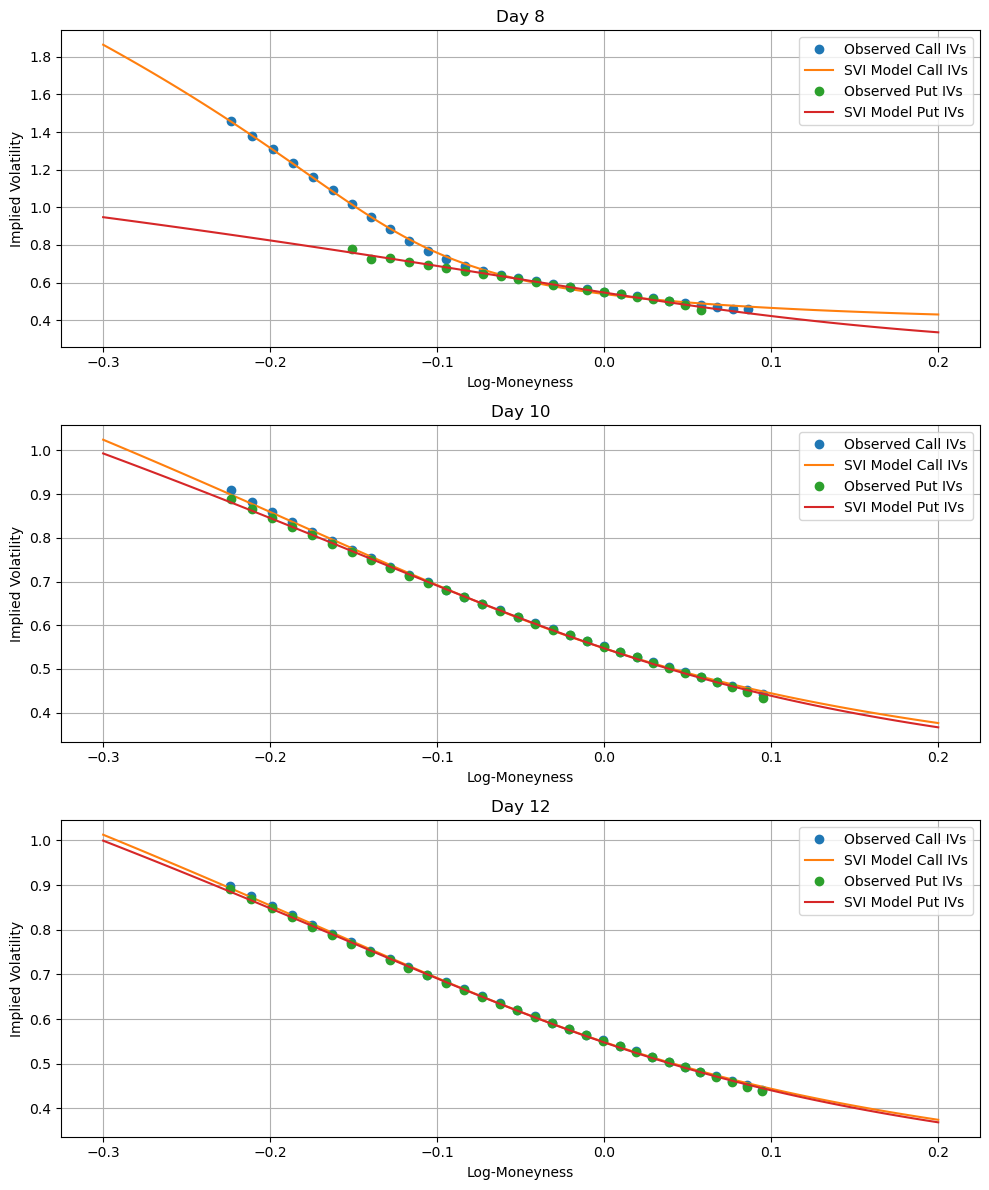

In [6]:
"""
SVI model
"""
from scipy.optimize import minimize
from itertools import product

# 'raw' SVI model for implied variance
def w_svi(k, a, b, rho, m, sigma):
    """ 
    Generally, for increasing parameter values, 
    a:     translates the curve upwards; 
    b:     increases the slopes of the ITM/OTM wings; 
    rho:   rotates the curve ccw;
    m:     shifts the curve right (with bottom being ATM);
    sigma: reduces the curvature ATM
    """
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# Least squares objective function to minimize
def svi_objective(params, k, implied_vol, weights = None):
    a, b, rho, m, sigma = params
    if weights is None:
        return np.sum((w_svi(k, a, b, rho, m, sigma) - implied_vol**2)**2)
    else:
        return np.sum(weights * (np.sqrt(w_svi(k, a, b, rho, m, sigma)) - implied_vol)**2)

def fit_svi(S, day, df, option_type, weighted = True):
    strikes = df.dropna(subset = f"{option_type}_IV").index.values
    IVs = df.loc[strikes][f"{option_type}_IV"]
    k = np.log(strikes/(S * np.exp(r * (day - 7)/365)))

    # Weights for least squares
    if weighted:
        # Might want to consider different weighting methods
        weights = np.exp(-1/np.maximum((1 - (strikes - S_abc)**2 / 400), 1e-10))
    else:
        weights = None

    # Grid search for initial parameters (a, b, rho, m, sigma)  

    a_range = np.linspace(0, 1, 2)
    b_range = np.linspace(1, 3, 3)
    rho_range = np.linspace(-1, 0, 3)
    m_range = np.linspace(-0.1, 0.1, 3)
    sigma_range = np.linspace(0.1, 0.3, 3)
    init_params = product(a_range, b_range, rho_range, m_range, sigma_range)
    
    best_rmse = float('inf')
    best_params = None
    best_predicted_ivs = None

    bounds = [(0, None), (0, None), (-1, 1), (None, None), (0, None)]
    
    for init in init_params:
        result = minimize(svi_objective, x0=init, args=(k, IVs, weights), bounds=bounds)
        a, b, rho, m, sigma = result.x
        predicted_ivs = np.sqrt(w_svi(k, a, b, rho, m, sigma))
        rmse = np.sqrt(np.mean((IVs - predicted_ivs)**2))

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (a, b, rho, m, sigma)
            best_predicted_ivs = predicted_ivs

    a, b, rho, m, sigma = best_params
    print(f"Fitted {option_type} parameters for day {day}: a={a}, b={b}, rho={rho}, m={m}, sigma={sigma}.")

    predicted_ivs = np.sqrt(w_svi(k, a, b, rho, m, sigma))
    rmse = np.sqrt(np.mean((IVs - predicted_ivs)**2))
    print(f"RMSE: {rmse} \n")

    return (a, b, rho, m, sigma), IVs, k

def plot_svi(ax, k_call, IVs_call, k_put, IVs_put, k_grid, svi_vols_call, svi_vols_put, day):
    ax.plot(k_call, IVs_call, 'o', label='Observed Call IVs')
    ax.plot(k_grid, svi_vols_call, '-', label='SVI Model Call IVs')
    ax.plot(k_put, IVs_put, 'o', label='Observed Put IVs')
    ax.plot(k_grid, svi_vols_put, '-', label='SVI Model Put IVs')
    ax.set_xlabel('Log-Moneyness')
    ax.set_ylabel('Implied Volatility')
    ax.set_title(f'Day {day}')
    ax.legend()
    ax.grid(True)

fig, axs = plt.subplots(3, figsize=(10, 12))

# Dicts to store fitted parameters, empirical IVs, and corresponding log-moneyness values for each day in [8, 10, 12]
svi_params = {"Call":{}, "Put":{}}
IVs = {"Call":{}, "Put":{}}
k_valid = {"Call":{}, "Put":{}}

for day, df in abc_data.items():
    if day in [9, 11]:
        continue
        
    weighted = False
    # Fit parameters
    (a_call, b_call, rho_call, m_call, sigma_call), IVs_call, k_call = fit_svi(S_abc, day, df, "Call", weighted=weighted)
    (a_put, b_put, rho_put, m_put, sigma_put), IVs_put, k_put = fit_svi(S_abc, day, df, "Put", weighted=weighted)

    # Store parameters, strikes, and IVs
    svi_params["Call"][day] = (a_call, b_call, rho_call, m_call, sigma_call)
    svi_params["Put"][day] = (a_put, b_put, rho_put, m_put, sigma_put)
    IVs["Call"][day] = IVs_call
    IVs["Put"][day] = IVs_put
    k_valid["Call"][day] = k_call
    k_valid["Put"][day] = k_put

    # Generate desired range of log-moneyness for plotting
    k_range = np.linspace(-0.3, 0.2, 101)
    svi_vols_call = np.sqrt(w_svi(k_range, a_call, b_call, rho_call, m_call, sigma_call))
    svi_vols_put = np.sqrt(w_svi(k_range, a_put, b_put, rho_put, m_put, sigma_put))
    
    plot_svi(axs[int((day - 8)/2)], k_call, IVs_call, k_put, IVs_put, k_range, svi_vols_call, svi_vols_put, day)


plt.tight_layout()
plt.show()

In [7]:
"""
Interpolate the SVI slices
"""
from scipy.interpolate import interp1d

# Collect all log-moneyness values corresponding to ABC option strikes and maturities
strikes = range(80, 111)
k_values = []
for day in range(8, 13):
    k_values.append([np.log(strike/(S_abc * np.exp(r * (day-7)/365))) for strike in strikes])
    
# Form grid of log-moneyness values for surface construction
k_grid = np.concatenate([np.linspace(-0.3, 0.22, 101), *k_values])
k_grid = np.unique(k_grid)

# Compute total variance for Days 8, 10, 12 at all log-moneyness values in 'k_grid'
tot_var = {"Call":{}, "Put":{}}
for option_type in ["Call", "Put"]:
    for day in [8, 10, 12]:
        tot_var[option_type][day] = [w_svi(k, *svi_params[option_type][day])*(day-7)/365 for k in k_grid]


# Choose maturities for interpolation
T_grid = np.linspace(1/365, 5/365, 101)

# Specify times at which have total variances, for use in 'interp1d' method
T_values = np.array([1,3,5])/365


# Define dict to hold arrays to hold IV surface values
IV_surface = {"Call":np.zeros((len(T_grid), len(k_grid))), "Put":np.zeros((len(T_grid), len(k_grid)))}


# Interpolate total variance along each log-moneyness slice and fill IV surface arrays
for i, k in enumerate(k_grid):
    for option_type in ["Call", "Put"]:
        # Collect the three known total variances
        total_vars_at_k = [tot_var[option_type][day][i] for day in [8, 10, 12]]

        # Construct linearly interpolated function using given inputs 'T_values' and outputs 'total_vars_at_k'
        tot_var_interpolator_at_k = interp1d(T_values, total_vars_at_k, kind="linear")

        # Evaluate the function at all maturities in 'T_grid'
        interpolated_tot_vars = tot_var_interpolator_at_k(T_grid)

        # Store the IV values resulting from interpolated total variances
        IV_surface[option_type][:, i] = np.sqrt(interpolated_tot_vars/T_grid)
        

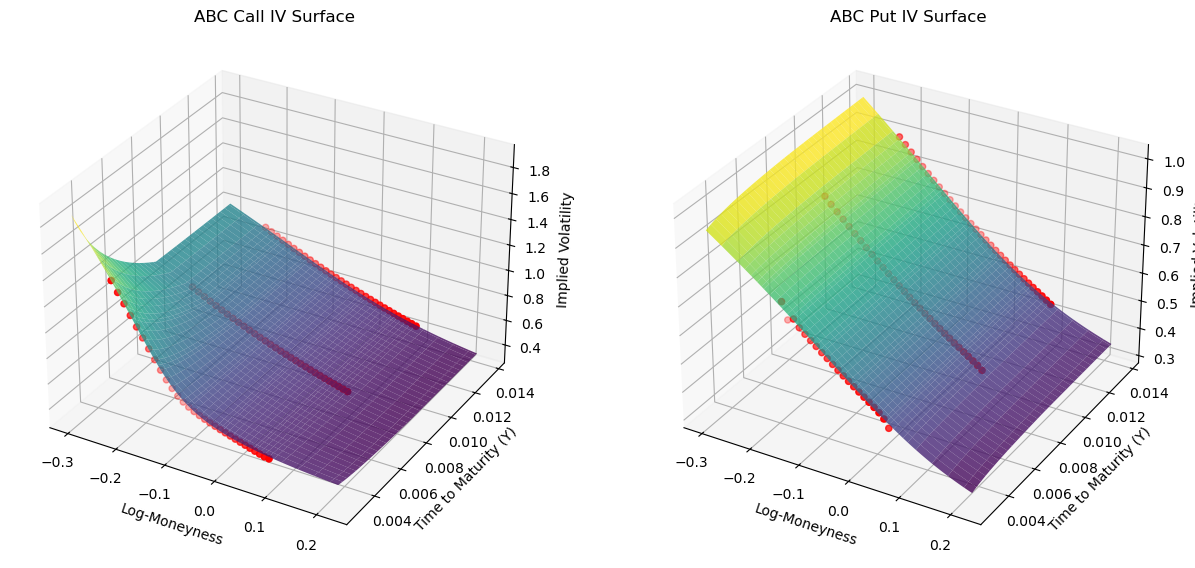

In [15]:
"""
Plot the interpolated IV surfaces
"""
fig = plt.figure(figsize=(15, 10))

# Plot Call IV Surface
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(k_grid, T_grid)
ax1.plot_surface(X, Y, IV_surface["Call"], cmap='viridis', alpha=.8)
ax1.set_xlabel('Log-Moneyness')
ax1.set_ylabel('Time to Maturity (Y)')
ax1.set_zlabel('Implied Volatility')
ax1.set_title('ABC Call IV Surface')


# Plot Put IV Surface
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, IV_surface["Put"], cmap='viridis', alpha=.8)
ax2.set_xlabel('Log-Moneyness')
ax2.set_ylabel('Time to Maturity (Y)')
ax2.set_zlabel('Implied Volatility')
ax2.set_title('ABC Put IV Surface')

# Include empirical data in plot
for day in [8, 10, 12]:
    T = (day - 7)/365
    ax1.scatter(k_valid["Call"][day], T, IVs["Call"][day], color='r', label=f'Day {day}')
    ax2.scatter(k_valid["Put"][day], T, IVs["Put"][day], color='r', label=f'Day {day}')

plt.savefig("SVI_surfaces.png")
plt.show()

In [9]:
"""
Use IV surfaces to estimate prices
"""
strikes = np.array(range(80, 111))

for day in range(8, 13):
    T = (day - 7)/365

    strike_indices = np.searchsorted(k_grid, k_values[day-8])
    T_index = np.searchsorted(T_grid, T)
    
    for option_type in ["Call", "Put"]:
        if day in [8,10,12]:
            abc_data[day][f"SVI {option_type} estimate"] = bsm_price(S_abc, strikes, T, r, IV_surface[option_type][T_index, strike_indices], option_type)
        else:
            abc_data[day][f"{option_type}"] = bsm_price(S_abc, strikes, T, r, IV_surface[option_type][T_index, strike_indices], option_type)
    

In [ ]:
abc_data[9][["Call", "Put"]].map(lambda x: f"{x:.4f}").to_csv("./ABC_2024-01-09.csv")
abc_data[11][["Call", "Put"]].map(lambda x: f"{x:.4f}").to_csv("./ABC_2024-01-11.csv")

In [10]:
dfs = []
for day, df in abc_data.items():
    if day in [9,11]: 
        temp = df.copy()[["Call", "Put"]]
        temp.columns = pd.MultiIndex.from_product([[f"Day {day}"], temp.columns])
        dfs.append(temp)

display(pd.concat(dfs, axis=1))

Day 9         Day 11       
          Call    Put    Call    Put
Strike                              
80     20.0267 0.0004 20.0675 0.0212
81     19.0279 0.0006 19.0739 0.0269
82     18.0292 0.0010 18.0818 0.0341
83     17.0307 0.0016 17.0915 0.0431
84     16.0326 0.0026 16.1037 0.0547
85     15.0351 0.0040 15.1190 0.0694
86     14.0382 0.0063 14.1382 0.0881
87     13.0425 0.0099 13.1625 0.1119
88     12.0486 0.0154 12.1932 0.1422
89     11.0574 0.0240 11.2321 0.1809
90     10.0703 0.0371 10.2815 0.2302
91      9.0896 0.0569  9.3441 0.2928
92      8.1182 0.0868  8.4236 0.3722
93      7.1608 0.1312  7.5240 0.4726
94      6.2236 0.1963  6.6504 0.5990
95      5.3149 0.2904  5.8087 0.7570
96      4.4453 0.4234  5.0053 0.9532
97      3.6276 0.6078  4.2474 1.1946
98      2.8758 0.8570  3.5423 1.4884
99      2.2040 1.1846  2.8971 1.8418
100     1.6244 1.6027  2.3179 2.2610
101     1.1447 2.1196  1.8096 2.7509
102     0.7667 2.7377  1.3747 3.3143
103     0.4851 3.4527  1.0133 3.9514
104     0.2881 4.2535  0.7226 4.6595
105     0.1596 5.1244  0.4969 5.4332
106     0.0820 6.0474  0.3285 6.2645
107     0.0388 7.0054  0.2081 7.1443
108     0.0169 7.9846  0.1260 8.0625
109     0.0067 8.9754  0.0726 9.0096
110     0.0024 9.9716  0.0397 9.9772

In [11]:
"""
Use moneyness scaling to relate LABC option prices to ABC option prices
"""
beta = 3  # leverage ratio

# Volatility curves at given dates of interest
IV_slices = {"Call":{}, "Put":{}}
for option_type in ["Call", "Put"]:
    for day in range(8, 13):
        T_index = np.searchsorted(T_grid, T)
        IV_slices[option_type][day] = interp1d(k_grid, IV_surface[option_type][T_index, :], kind="cubic")

# Find IV and log-moneyness of ABC options corresponding to given LABC log-moneyness, using Leung-Sircar's 'moneyness scaling'
def k_labc_to_IV_abc(k_labc, day, beta, r, option_type):
    T = (day-7)/365

    # Consider slice of IV surface at tenor T
    IV_slice = IV_slices[option_type][day]

    # Find average IV for slice for use in moneyness scaling formula
    k_inputs = np.linspace(min(k_values[day-8]), max(k_values[day-8]), 101)
    
    sigma = np.mean(IV_slice(k_inputs))
    
    # Convert forward log-moneyness k_labc to present log-moneyness a la Leung-Sircar
    k_LS = k_labc + r*T
    
    # Use simplified moneyness scaling formula of Leung-Sircar
    k_abc = (k_LS + r*(beta - 1)*T + 0.5*beta*(beta - 1)*T*(sigma**2))/beta - r*T
    
    return IV_slice(k_abc)

# Find predicted prices of LABC options
for day, df in labc_data.items():
    T = (day - 7)/365

    df["log-moneyness"] = np.log(df.index.values/(S_labc * np.exp(r * T)))

    for option_type in ["Call", "Put"]:
        if day in [8, 10]:
            df[f"{option_type} est. price"] = df.apply(
                lambda row: bsm_price(S_labc, row.name, T, r, 
                                      beta*k_labc_to_IV_abc(row["log-moneyness"], day, beta, r, option_type), 
                                      option_type), axis=1)
        else:
            df[option_type] = df.apply(
                lambda row: bsm_price(S_labc, row.name, T, r, 
                                      beta*k_labc_to_IV_abc(row["log-moneyness"], day, beta, r, option_type), 
                                      option_type), axis=1)
        

In [ ]:
labc_data[9][["Call", "Put"]].map(lambda x: f"{x:.4f}").to_csv("./LABC_2024-01-09.csv")
labc_data[11][["Call", "Put"]].map(lambda x: f"{x:.4f}").to_csv("./LABC_2024-01-11.csv")
labc_data[12][["Call", "Put"]].map(lambda x: f"{x:.4f}").to_csv("./LABC_2024-01-12.csv")

In [12]:
dfs = []
for day, df in labc_data.items():
    if day in [9, 11, 12]:
        temp = df.copy()[["Call", "Put"]]
        temp.columns = pd.MultiIndex.from_product([[f"Day {day}"], temp.columns])
        dfs.append(temp)

display(pd.concat(dfs, axis=1))

Day 9          Day 11          Day 12        
          Call     Put    Call     Put    Call     Put
Strike                                                
15     15.0044  0.0002 15.0216  0.0124 15.0420  0.0297
16     14.0050  0.0005 14.0289  0.0190 14.0555  0.0424
17     13.0059  0.0011 13.0394  0.0287 13.0737  0.0597
18     12.0074  0.0023 12.0541  0.0428 12.0979  0.0832
19     11.0101  0.0047 11.0748  0.0629 11.1303  0.1149
20     10.0148  0.0091 10.1040  0.0915 10.1732  0.1574
21      9.0233  0.0173  9.1446  0.1318  9.2301  0.2139
22      8.0382  0.0319  8.2010  0.1877  8.3050  0.2884
23      7.0640  0.0574  7.2781  0.2646  7.4028  0.3858
24      6.1073  0.1004  6.3826  0.3687  6.5293  0.5119
25      5.1776  0.1704  5.5220  0.5077  5.6912  0.6733
26      4.2878  0.2802  4.7048  0.6899  4.8957  0.8771
27      3.4536  0.4455  3.9402  0.9244  4.1503  1.1306
28      2.6924  0.6837  3.2371  1.2202  3.4622  1.4412
29      2.0212  1.0117  2.6036  1.5854  2.8377  1.8152
30      1.4533  1.4428  2.0459  2.0262  2.2819  2.2576
31      0.9956  1.9842  1.5674  2.5462  1.7975  2.7715
32      0.6464  2.6344  1.1685  3.1460  1.3851  3.3574
33      0.3958  3.3835  0.8462  3.8226  1.0427  4.0136
34      0.2275  4.2154  0.5941  4.5698  0.7659  4.7358
35      0.1223  5.1105  0.4039  5.3792  0.5483  5.5175
36      0.0613  6.0498  0.2654  6.2408  0.3822  6.3511
37      0.0286  7.0174  0.1685  7.1440  0.2592  7.2281
38      0.0123  8.0013  0.1032  8.0790  0.1709  8.1400
39      0.0049  8.9939  0.0609  9.0370  0.1095  9.0788
40      0.0018  9.9907  0.0346 10.0109  0.0681 10.0376
41      0.0006 10.9893  0.0190 10.9953  0.0411 11.0108
42      0.0002 11.9887  0.0100 11.9862  0.0241 11.9937
43      0.0001 12.9883  0.0051 12.9811  0.0137 12.9832
44      0.0000 13.9880  0.0025 13.9781  0.0076 13.9767
45      0.0000 14.9877  0.0012 14.9764  0.0041 14.9728
46      0.0000 15.9874  0.0005 15.9753  0.0021 15.9704
47      0.0000 16.9871  0.0002 16.9744  0.0011 16.9687
48      0.0000 17.9869  0.0001 17.9738  0.0005 17.9676
49      0.0000 18.9866  0.0000 18.9732  0.0003 18.9667
50      0.0000 19.9863  0.0000 19.9726  0.0001 19.9659
51      0.0000 20.9860  0.0000 20.9721  0.0001 20.9651
52      0.0000 21.9858  0.0000 21.9715  0.0000 21.9644
53      0.0000 22.9855  0.0000 22.9710  0.0000 22.9637
54      0.0000 23.9852  0.0000 23.9704  0.0000 23.9630
55      0.0000 24.9849  0.0000 24.9699  0.0000 24.9623

The below code is scratch work. 

In [13]:
"""
Heston Model
"""
def heston_char_func(u, T, v0, kappa, theta, sigma, rho):
    """
    Stable Heston characteristic function of Cui, et. al.. 
    Args:
        u: Argument of the characteristic function.
        T: Time to maturity.
        v0: Initial variance.
        kappa: Mean reversion speed. This is \tilde{v} in Cui, et. al.
        theta: Long-term variance.
        sigma: Volatility of variance. (vol of vol is a misnomer)
        rho: Correlation between asset and variance processes.
    """
    xi = kappa - sigma*rho*1j*u
    d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j*u))
    A1 = (u**2 + 1j*u)*np.sinh(d*T/2)
    A2 = (d/v0)*np.cosh(d*T/2) + (xi/v0)*np.sinh(d*T/2)
    A = A1 / A2
    D = np.log(d/v0) + (kappa - d)*T/2 - np.log((d+xi)/(2*v0) + (d - xi)*np.exp(-d*T)/(2*v0))
    B = np.exp(D)

    return np.exp(1j*u*r*T - kappa*theta*rho*T*1j*u/sigma - A + 2*kappa*theta*D/(sigma**2))

# Equation 9 of Cui, et. al.
def heston_price(S, K, T, v0, kappa, theta, sigma, rho, option_type):
    # Vectorized quadrature set up
    n_nodes = 64
    u_grid, weights = np.polynomial.legendre.leggauss(n_nodes)
    u_bar = 200
    u_grid = (u_grid + 1)*u_bar/2
    weights = weights*u_bar/2

    u_grid = u_grid[:, np.newaxis]
    
    integrand1 = np.real((np.exp(-1j*u_grid*np.log(K/S_abc))/(1j*u_grid)) * 
                           heston_char_func(u_grid - 1j, T, v0, kappa, theta, sigma, rho))

    integrand2 = np.real((np.exp(-1j*u_grid*np.log(K/S_abc))/(1j*u_grid)) * 
                   heston_char_func(u_grid, T, v0, kappa, theta, sigma, rho))
    
    # Perform vectorized Gauss-Legendre integration
    integral1 = np.sum(integrand1 * weights[:, np.newaxis], axis=0)
    integral2 = np.sum(integrand2 * weights[:, np.newaxis], axis=0)

    integral = S_abc*integral1 - K*integral2
    
    if option_type == "Call":
        return (S - K*np.exp(-r*T))/2 + (np.exp(-r*T)/np.pi)*integral
    else:
        return (K*np.exp(-r*T) - S)/2 + (np.exp(-r*T)/np.pi)*integral

# Sum of sq of model and empirical price differences across all strikes and maturities
def heston_objective(params, days, abc_data, option_type):
    # Create arrays of same shape to store strikes, maturities, and observed prices
    strikes = []
    maturities = []
    observed_prices = []
    
    for day in days:
        T = (day - 7) / 365
        df = abc_data[day]
        strikes.extend(df.index.values)
        maturities.extend([T]*len(df))
        observed_prices.extend(df[f"{option_type}"].values) 

    strikes = np.array(strikes)
    maturities = np.array(maturities)
    observed_prices = np.array(observed_prices)

    # Broadcast for vectorized calculation by 'heston_price' function
    strikes = strikes[np.newaxis, :]
    maturities = maturities[np.newaxis, :]

    model_prices = heston_price(S_abc, strikes, maturities, *params, option_type)
    
    squared_errors = (observed_prices - model_prices)**2
    return np.sum(squared_errors)

def heston_gradient(params, days, abc_data, option_type):
    v0, kappa, theta, sigma, rho = params
    grad = np.zeros(5, dtype=np.complex128)  # Initialize gradient vector

    # Vectorized Gauss-Legendre integration scheme's nodes and weights
    n_nodes = 256
    u_grid, weights = np.polynomial.legendre.leggauss(n_nodes)
    
    # Scale nodes to the truncated integration range [0, u_bar]
    u_bar = 3000
    u_grid = (u_grid + 1)*u_bar/2
    weights = weights*u_bar/2
    
    # Loop over days to calculate contribution to gradient
    for day in days:
        T = (day - 7)/365
        df = abc_data[day]
        strikes = df.index.values

        # Get characteristic function values
        phi = heston_char_func(u_grid, T, *params)
        
        # Define common terms
        xi = kappa - sigma*rho*1j*u_grid
        d = np.sqrt(xi**2 + sigma**2 * (u_grid**2 + 1j*u_grid))
        A1 = (u_grid**2 + 1j*u_grid)*np.sinh(d*T/2)
        A2 = (d/v0)*np.cosh(d*T/2) + (xi/v0)*np.sinh(d*T/2)
        A = A1/A2
        D = np.log(d/v0) + (kappa-d)*T/2 - np.log((d+xi)/(2*v0) + (d-xi)*np.exp(-d*T)/(2*v0))
        B = np.exp(D)
        
        # Compute partial derivatives
        dA1_drho = -1j*u_grid*(u_grid**2 + 1j*u_grid)*T*xi*sigma*np.cosh(d*T/2)/(2*d)
        dA2_drho = -sigma*1j*u_grid*(2+xi*T)*(xi*np.cosh(d*T/2)+d*np.sinh(d*T/2))/(2*d*v0)
        dA_drho = (dA1_drho - A*dA2_drho)/A2
        dd_drho = -xi*sigma*1j*u_grid/d
        dB_drho = np.exp(kappa*T/2)*(dd_drho - d*dA2_drho/A2)/(v0*A2)
        dB_dkappa = 1j*dB_drho/(sigma*u_grid) + B*T/2
        dd_dsigma = (rho/sigma - 1/xi)*dd_drho + sigma*(u_grid**2)/d
        dA1_dsigma = (u_grid**2 + 1j*u_grid)*T*dd_dsigma*np.cosh(d*T/2)/2
        dA2_dsigma = rho*dA2_drho/sigma - (2+T*xi)*dA1_drho/(v0*T*xi*1j*u_grid) + sigma*T*A1/(2*v0)
        dA_dsigma = (dA1_dsigma - A*dA2_dsigma)/A2

        # Initialize array for five concurrent quadrature operations
        h = np.zeros((len(u_grid), 5), dtype=np.complex128)
        
        # Define integrands for each quadrature operation
        h[:, 0] = -A/v0
        h[:, 1] = 2*kappa*D/(sigma**2) - kappa*rho*T*1j*u_grid/sigma
        h[:, 2] = (-dA_drho + 2*kappa*theta/(sigma**2*d) * (dd_drho - (d/A2)*dA2_drho) - 
            kappa*theta*T*1j*u_grid/sigma)
        h[:, 3] = (dA_drho/(sigma*1j*u_grid) + 2*theta*D/(sigma**2) + 
            2*kappa*theta*dB_dkappa/(sigma**2 * B) - theta*rho*T*1j*u_grid/sigma)
        h[:, 4] = (-dA_dsigma - 4*kappa*theta*D/(sigma**3) + kappa*theta*rho*T*1j*u_grid/(sigma**2) + 
            (2*kappa*theta/(sigma**2 * d))*(dd_dsigma - d*dA2_dsigma/A2))

        # Broadcast explicitly
        phi = phi[:,np.newaxis, np.newaxis]         # Shape (n_nodes, 1, 1)
        h = h[:,:,np.newaxis]                       # Shape (n_nodes, 5, 1)
        strikes = strikes[np.newaxis,np.newaxis,:]  # Shape (1, 1, n_strikes)
        u_grid = u_grid[:,np.newaxis, np.newaxis]   # Shape (n_nodes, 1, 1)

        # Perform vectorized quadrature
        integrands = phi*h*((strikes/S_abc)**(-1j*u_grid))/(1j*u_grid)
        integral_results = np.sum(integrands*weights[:, np.newaxis, np.newaxis], axis=0)  
        grad += np.sum(integral_results, axis=1)

        u_grid = u_grid.reshape(n_nodes, )
        
    return grad.real


Fitted Call Heston parameters: v0=0.4250, kappa=0.5011, 
        theta=0.1017, sigma=0.1000, rho=-0.5079
RMSE: 0.2107624531200195

Fitted Put Heston parameters: v0=0.4250, kappa=0.5011, 
        theta=0.1017, sigma=0.1000, rho=-0.5079
RMSE: 0.12502246246201415



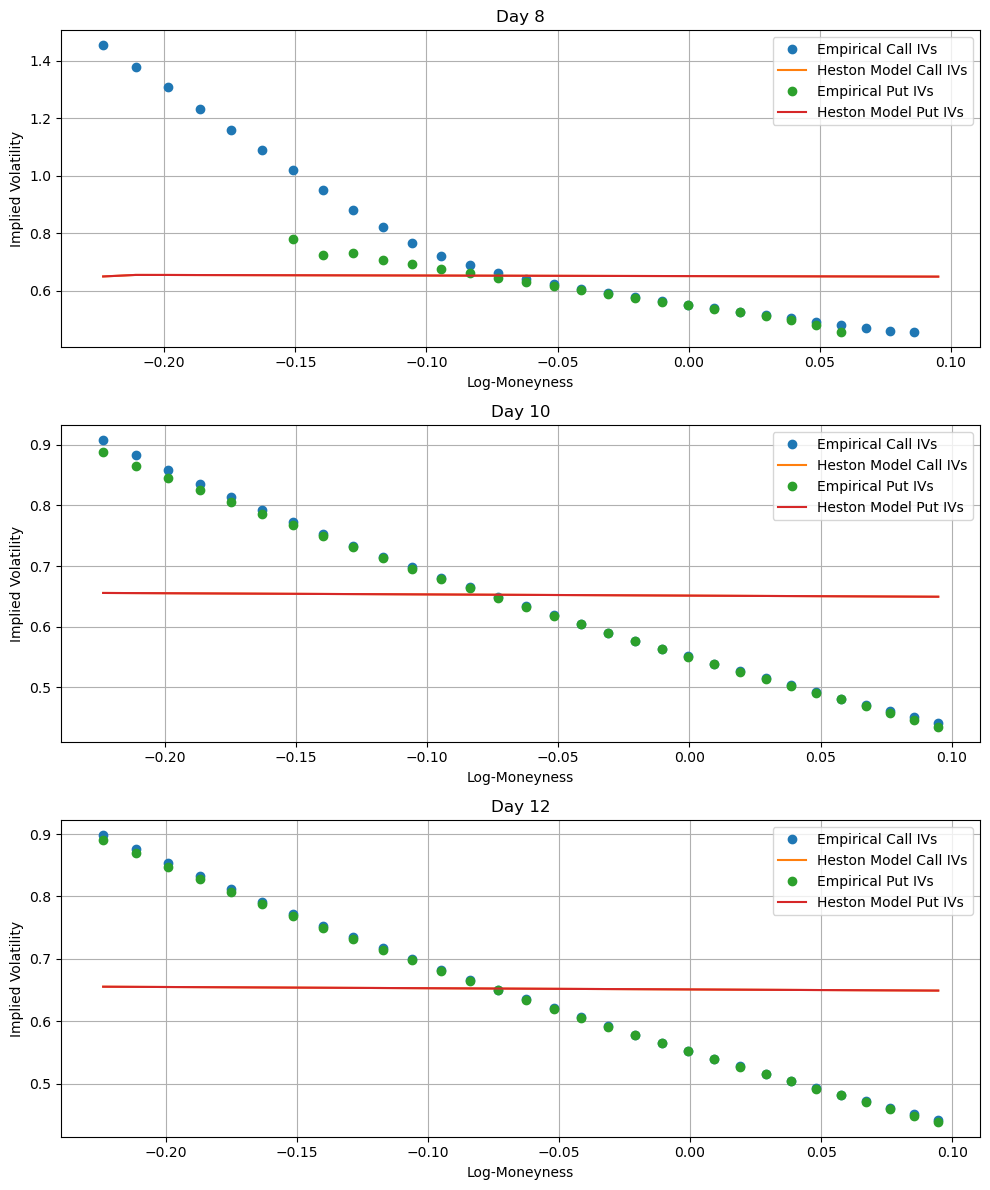

In [14]:
"""
Fit Heston model and plot
"""

def plot_heston(ax, strikes, observed_ivs, model_ivs, day, option_type):
    k = np.log(strikes / (S_abc * np.exp(r * (day - 7) / 365)))
    mask = ~pd.isna(observed_ivs)
    ax.plot(k[mask], observed_ivs[mask], 'o', label=f'Empirical {option_type} IVs')
    ax.plot(k, model_ivs, '-', label=f'Heston Model {option_type} IVs')
    ax.set_xlabel('Log-Moneyness')
    ax.set_ylabel('Implied Volatility')
    ax.set_title(f'Day {day}')
    ax.legend()
    ax.grid(True)
    
fig, axs = plt.subplots(3, figsize=(10, 12))
days = [8, 10, 12]

heston_params = {} 
heston_IVs = {}

for option_type in ["Call", "Put"]:
    # Initial guess for parameters (v0, kappa, theta, sigma, rho)
    init_params = (0.1, 0.5, 0.1, 0.1, -0.5)
    
    result = minimize(heston_objective, 
                          x0=init_params, 
                          args=(days, abc_data, option_type), 
                          bounds=[(1e-6, None), (1e-4, 10), (1e-6, None), (1e-6, 4), (-1, 1)], 
                          jac=heston_gradient)
    
    fit_params = result.x
    heston_params[option_type] = fit_params

    for day in days:
        T = (day - 7) / 365
        df = abc_data[day]
        strikes = df.index.values
        model_prices = [heston_price(S_abc, K, T, *fit_params, option_type) for K in strikes]
        heston_IVs[day] = [price_to_IV(S_abc, K, T, r, price, option_type) 
                                    for K, price in zip(strikes, model_prices)]
        df[f"{option_type} Heston Price"] = model_prices
        df[f"{option_type} Heston IV"] = heston_IVs[day]

    # Calculate RMSE
    empirical_ivs = [abc_data[day].dropna(subset=[f"{option_type}_IV"])[f"{option_type}_IV"].values for day in days]
    empirical_ivs = np.concatenate(empirical_ivs)
    model_ivs = [abc_data[day].dropna(subset=[f"{option_type}_IV"])[f"{option_type} Heston IV"].values for day in days]
    model_ivs = np.concatenate(model_ivs)
    rmse = np.sqrt(np.mean((empirical_ivs - model_ivs) ** 2))

    v0, kappa, theta, sigma, rho = fit_params
    print(f"""Fitted {option_type} Heston parameters: v0={v0:.4f}, kappa={kappa:.4f}, 
        theta={theta:.4f}, sigma={sigma:.4f}, rho={rho:.4f}""")
    print(f"RMSE: {rmse}\n")

    # Calculate and plot model IVs for each day
    for i, day in enumerate(days):
        T = (day - 7) / 365
        df = abc_data[day]
        strikes = df.index.values
        empirical_ivs = df[f"{option_type}_IV"]
        model_ivs = df[f"{option_type} Heston IV"]
        plot_heston(axs[i], strikes, empirical_ivs, model_ivs, day, option_type)

        # # Save each subplot as a separate file
        # plt.figure(i+1).savefig(f'heston_fit_day_{day}_{option_type}.png')

plt.tight_layout()
plt.show()

In [ ]:
"""
Reset DataFrames
"""
df = pd.DataFrame(index=range(80,111), columns = ["Call", "Put"])
df2 = pd.DataFrame(index=range(15,56), columns = ["Call", "Put"])
for day in [9, 11]:
    df.to_csv(f"./ABC_2024-01-{day:02d}.csv")
    df2.to_csv(f"./LABC_2024-01-{day:02d}.csv")
df2.to_csv("./LABC_2024-01-12.csv")

In [ ]:
"""
Compare moneyness scaling method with SVI interpolation and extrapolation
"""
# Warning: Code below is largely copy and pasted from above without properly renamed variables

fig, axs = plt.subplots(2, figsize=(10, 12))

# Dicts to store fitted parameters, empirical IVs, and corresponding log-moneyness values for each day
svi_params = {"Call":{}, "Put":{}}
IVs = {"Call":{}, "Put":{}}
k_valid = {"Call":{}, "Put":{}}

for day, df in labc_data.items():
    if day in [9, 11, 12]:
        continue
        
    weighted = False
    # Fit parameters
    (a_call, b_call, rho_call, m_call, sigma_call), IVs_call, k_call = fit_svi(S_labc, day, df, "Call", weighted=weighted)
    (a_put, b_put, rho_put, m_put, sigma_put), IVs_put, k_put = fit_svi(S_labc, day, df, "Put", weighted=weighted)

    # Store parameters, strikes, and IVs
    svi_params["Call"][day] = (a_call, b_call, rho_call, m_call, sigma_call)
    svi_params["Put"][day] = (a_put, b_put, rho_put, m_put, sigma_put)
    IVs["Call"][day] = IVs_call
    IVs["Put"][day] = IVs_put
    k_valid["Call"][day] = k_call
    k_valid["Put"][day] = k_put

    # Generate desired range of log-moneyness for plotting
    k_range = np.linspace(-0.7, 0.7, 101)
    svi_vols_call = np.sqrt(w_svi(k_range, a_call, b_call, rho_call, m_call, sigma_call))
    svi_vols_put = np.sqrt(w_svi(k_range, a_put, b_put, rho_put, m_put, sigma_put))
    
    plot_svi(axs[int((day - 8)/2)], k_call, IVs_call, k_put, IVs_put, k_range, svi_vols_call, svi_vols_put, day)


plt.tight_layout()
plt.show()

# Collect all log-moneyness values corresponding to LABC option strikes and maturities
strikes = range(15, 56)
k_values = []
for day in range(8, 13):
    k_values.append([np.log(strike/(S_labc * np.exp(r * (day-7)/365))) for strike in strikes])
    
# Form grid of log-moneyness values for surface construction
k_grid = np.concatenate([np.linspace(-0.7, 0.7, 101), *k_values])
k_grid = np.unique(k_grid)

# Compute total variance for Days 8 and 10 at all log-moneyness values in 'k_grid'
tot_var = {"Call":{}, "Put":{}}
for option_type in ["Call", "Put"]:
    for day in [8, 10]:
        tot_var[option_type][day] = [w_svi(k, *svi_params[option_type][day])*(day-7)/365 for k in k_grid]


# Choose maturities for interpolation
T_grid = np.linspace(1/365, 5/365, 101)

# Specify times at which have total variances, for use in 'interp1d' method
T_values = np.array([1,3])/365


# Define dict to hold arrays to hold IV surface values
IV_surface = {"Call":np.zeros((len(T_grid), len(k_grid))), "Put":np.zeros((len(T_grid), len(k_grid)))}


# Interpolate total variance along each log-moneyness slice and fill IV surface arrays
for i, k in enumerate(k_grid):
    for option_type in ["Call", "Put"]:
        # Collect the three known total variances
        total_vars_at_k = [tot_var[option_type][day][i] for day in [8, 10]]

        # Construct linearly interp/extrapolated function using given inputs 'T_values' and outputs 'total_vars_at_k'
        tot_var_interpolator_at_k = interp1d(T_values, total_vars_at_k, kind="linear", fill_value="extrapolate")

        # Evaluate the function at all maturities in 'T_grid'
        interpolated_tot_vars = tot_var_interpolator_at_k(T_grid)

        # Store the IV values resulting from interpolated total variances
        IV_surface[option_type][:, i] = np.sqrt(interpolated_tot_vars/T_grid)

for day in range(8, 13):
    T = (day - 7)/365

    strike_indices = np.searchsorted(k_grid, k_values[day-8])
    T_index = np.searchsorted(T_grid, T)
    
    for option_type in ["Call", "Put"]:
        labc_data[day][f"SVI {option_type} estimate"] = bsm_price(S_labc, df.index.values, T, r, 3*IV_surface[option_type][T_index, strike_indices], option_type)
    